In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import pandas as pd

import deep_fib
import utils

In [4]:
train, test = utils.data.get_train_test_split(0.01, 42)
dataset = utils.data.Marconi100Dataset(test, normalize=True)
dataset_deep_fib = deep_fib.data.DeepFIBDataset(dataset, 3)

100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


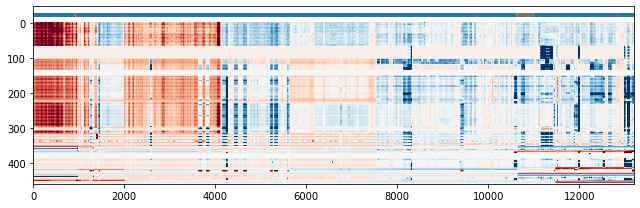

In [5]:
original, mask, (hpcsv, labels) = dataset_deep_fib[1]

utils.nn.plot_dataframe(hpcsv, pd.Series(labels.values))

In [6]:
original.shape

torch.Size([13195, 460])

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

horizon=1024
input_dim=460
num_encoder_levels=3
hidden_decoder_sizes=[2048]
batch_size=1

In [21]:
x = torch.stack([original[i:horizon+i] for i in range(batch_size)]).float().to(device)
print(x.size())

torch.Size([1, 1024, 460])


In [22]:
model = deep_fib.sci_net.SCINet(
    output_len=horizon,
    input_len=horizon,
    num_encoder_levels=num_encoder_levels,
    hidden_decoder_sizes=hidden_decoder_sizes,
    block_config=deep_fib.sci_net.SCIBlockCfg(
        input_dim=input_dim,
        hidden_size=16,
        kernel_size=3,
        dropout=0.5,
    )
).float().to(device)

y = model(x)
print(y.shape)


torch.Size([1, 1024, 460])


In [23]:
loss = torch.nn.L1Loss()
loss(x, y)

tensor(2.5258, grad_fn=<L1LossBackward0>)